<a href="https://www.kaggle.com/code/rodolphojustino/eda-of-logistics-data?scriptVersionId=121380159" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Author: Rodolpho Justino
### Data Analyst / Data Scientist

This is an exploratory data analysis of a logistics database from a company called loggi to find some insights about the dataset, the data is available [here](https://www.kaggle.com/datasets/franklinposso/loggi-deliveries)


The first step is to load the libraries

In [1]:
import pandas as pd
import numpy as np
import json
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats
import sklearn as skl

In [2]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json 

In [3]:
with open('deliveries.json', mode='r', encoding = 'utf8') as file:
    data = json.load(file)

In [4]:
len(data)

199

In [5]:
df = pd.DataFrame(data)

In [6]:
df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


We see that not all the data was retrieved correctly, for example, deliveries has a lot of values inside the column, our need is to "explode" the column in order to retrieve the data.

first we perform the operation on another column, the origin one

In [7]:
origin_df = pd.json_normalize(df["origin"])
origin_df.head()

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


The procedure worked, so we can merge the df with the previous one!

In [8]:
df = pd.merge(left = df, right = origin_df, how = "inner", left_index = True, right_index = True)
df.head()

,name,region,origin,vehicle_capacity,deliveries,lng,lat
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",-48.054989,-15.838145
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po...",-48.054989,-15.838145
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p...",-48.054989,-15.838145
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p...",-47.893662,-15.805118
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p...",-48.054989,-15.838145


We now remove the duplicate Origin column and rename the other ones

In [9]:
df = df.drop("origin", axis = 1)
df = df[["name","region", "lng", "lat", "vehicle_capacity", "deliveries"]]
df.rename(columns = {"lng":"hub_long","lat":"hub_lat"}, inplace = True)
df.head()

,name,region,hub_long,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Now, "exploding" the deliveries column, we perform the following operations

In [10]:
df_exploded = df[["deliveries"]].explode("deliveries")
df_exploded.head()

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."


In [11]:
new_df = pd.concat([pd.DataFrame(df_exploded["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
                    pd.DataFrame(df_exploded["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
                    pd.DataFrame(df_exploded["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"})
                   ], axis = 1)
new_df.head()

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


Now that we "exploded" the data, we merge it to the previous df

In [12]:
df = df.drop("deliveries", axis = 1)
df = pd.merge(left = df, right = new_df, how = "right", left_index = True, right_index = True )
df.reset_index(inplace = True, drop = True)
df

,name,region,hub_long,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055
...,...,...,...,...,...,...,...,...
636144,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,8,-48.064269,-15.997694
636145,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,4,-48.065176,-16.003597
636146,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,9,-48.065841,-16.003808
636147,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,1,-48.062327,-16.001568


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_long          636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


From the info above we can take different things:

* The data types are consistent with the data, no changes or conversions needed;
* There is no null data;
* there are 636 149 rows, each row represent a different delivery.

To confirm that there is no null o missing data, we use the following code line

In [14]:
df.isna().any()

name                False
region              False
hub_long            False
hub_lat             False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

## Using GeoCodification on the delivery hub

The reverse geocodification transforms the lat and long data in their respective text descriptions

In [15]:
hub_df = df[["region","hub_long","hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by = "region").reset_index(drop=True)
hub_df.head()

,region,hub_long,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


For this particular example, we will be using nominatim for the reverse geocodification

In [16]:
geolocator = Nominatim(user_agent = "logdata_geocoder")
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds = 1)

Because the geocoder needs data to be in string format of latitude and longitude, a conversion is needed

In [17]:
hub_df["coordinates"] = hub_df["hub_lat"].astype(str) + ", " + hub_df["hub_long"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_long,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Clinica dos Olhos, Rua 7, Quadra 2, Sobradinh..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíl..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [18]:
hub_geo_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geo_df.columns

Index(['place_id', 'licence', 'osm_type', 'osm_id', 'lat', 'lon',
       'display_name', 'boundingbox', 'address.amenity', 'address.road',
       'address.residential', 'address.suburb', 'address.town',
       'address.municipality', 'address.county', 'address.state_district',
       'address.state', 'address.ISO3166-2-lvl4', 'address.region',
       'address.postcode', 'address.country', 'address.country_code',
       'address.building', 'address.neighbourhood', 'address.city',
       'address.shop', 'address.house_number'],
      dtype='object')

In [19]:
hub_geo_df = hub_geo_df[["address.town", "address.suburb", "address.city"]]
hub_geo_df.rename(columns = {"address.town":"hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace = True)
#Here we take the city name, if there is not a city name, we search for it in the town column
hub_geo_df["hub_city"] = np.where(hub_geo_df["hub_city"].notna(), hub_geo_df["hub_city"],hub_geo_df["hub_town"])
#Same thing for the suburb, if there is not a suburb, we search for the information in the city column
hub_geo_df["hub_suburb"] = np.where(hub_geo_df["hub_suburb"].notna(), hub_geo_df["hub_suburb"], hub_geo_df["hub_city"])
#We drop the town column, as we already processed it
hub_geo_df = hub_geo_df.drop("hub_town", axis = 1)
hub_geo_df.head()

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


Now, it's time to combine the df with the information about the suburb and city with the main df

In [20]:
hub_df = pd.merge(left = hub_df, right = hub_geo_df, left_index = True, right_index = True)
hub_df = hub_df[["region","hub_suburb","hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [21]:
#Using the region column to perform an inner join of the dfs
df = pd.merge(left = df, right = hub_df, how = "inner", on = "region")
df = df[["name", "region","hub_long", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
df.head()
    

,name,region,hub_long,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


For the delivery dataset, with over 600 000 entries, the reversed geocodification was done locally on another machine and inserted on a different csv file, the data is available [here](https://www.kaggle.com/datasets/franklinposso/loggi-deliveries)

In [22]:
deliveries_geo_df = pd.read_csv("/kaggle/input/deliveries-geodata/deliveries-geodata.csv")
deliveries_geo_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


Now, merging this dataset with the main one:

In [23]:
df = pd.merge(left = df, right = deliveries_geo_df[["delivery_city","delivery_suburb"]], how = "inner", left_index = True, right_index = True)
df.head()

,name,region,hub_long,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


An important step after these steps is to check for missing data

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_long          636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 79.2+ MB


In [25]:
df.isna().any()

name                False
region              False
hub_long            False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

In [26]:
100 * (df["delivery_city"].isna().sum() / len(df))

0.26754738276724477

about ~ 0,27% of the City data is missing

In [27]:
100 * (df["delivery_suburb"].isna().sum() / len(df))

25.133262804783158

About ~ 25% of the suburb data is missing

In [28]:
prop_df = df[["delivery_city"]].value_counts() / len(df)
prop_df.sort_values(ascending = False).head(10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
dtype: float64

Another important insight that might have implications: 

* There is no "Brasilia City", there are regions which compose brasilia
* 25% of the data is listed as delivered in brasilia, these informations are unreliable

In [29]:
prop_df2 = df[["delivery_suburb"]].value_counts() / len(df)
prop_df2.sort_values(ascending = False).head(10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
dtype: float64

The same thing happens with the neighbourhoods:

* There is no Brasilia Neighbourhood, there are different neighbourhoods with different names
* The data here is more evenly spaced

## Visualizing the Data

In order to visualize the data in a map we need to work with a tool named geopandas

In [30]:
!pip install geopandas;

In [31]:
import geopandas

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Downloading and using Brasilia's Map from IBGEs DB

In [32]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [33]:
brmap = geopandas.read_file("distrito-federal.shp")
#using .loc[[0]] makes sure we are using only the Distrito Federal map, as the second row is related to Goias
brmap = brmap.loc[[0]]
brmap.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


Creating the GeoPoints for the Hubs

In [34]:
hub_df = df[["region","hub_long","hub_lat"]].drop_duplicates().reset_index(drop = True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry = geopandas.points_from_xy(hub_df["hub_long"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_long,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


Creating the GeoPoints for the deliveries

In [35]:
geo_dlv_df = geopandas.GeoDataFrame(df, geometry = geopandas.points_from_xy(df["delivery_lng"], df["delivery_lat"]))
geo_dlv_df.head()

,name,region,hub_long,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


Starting to set up the viz

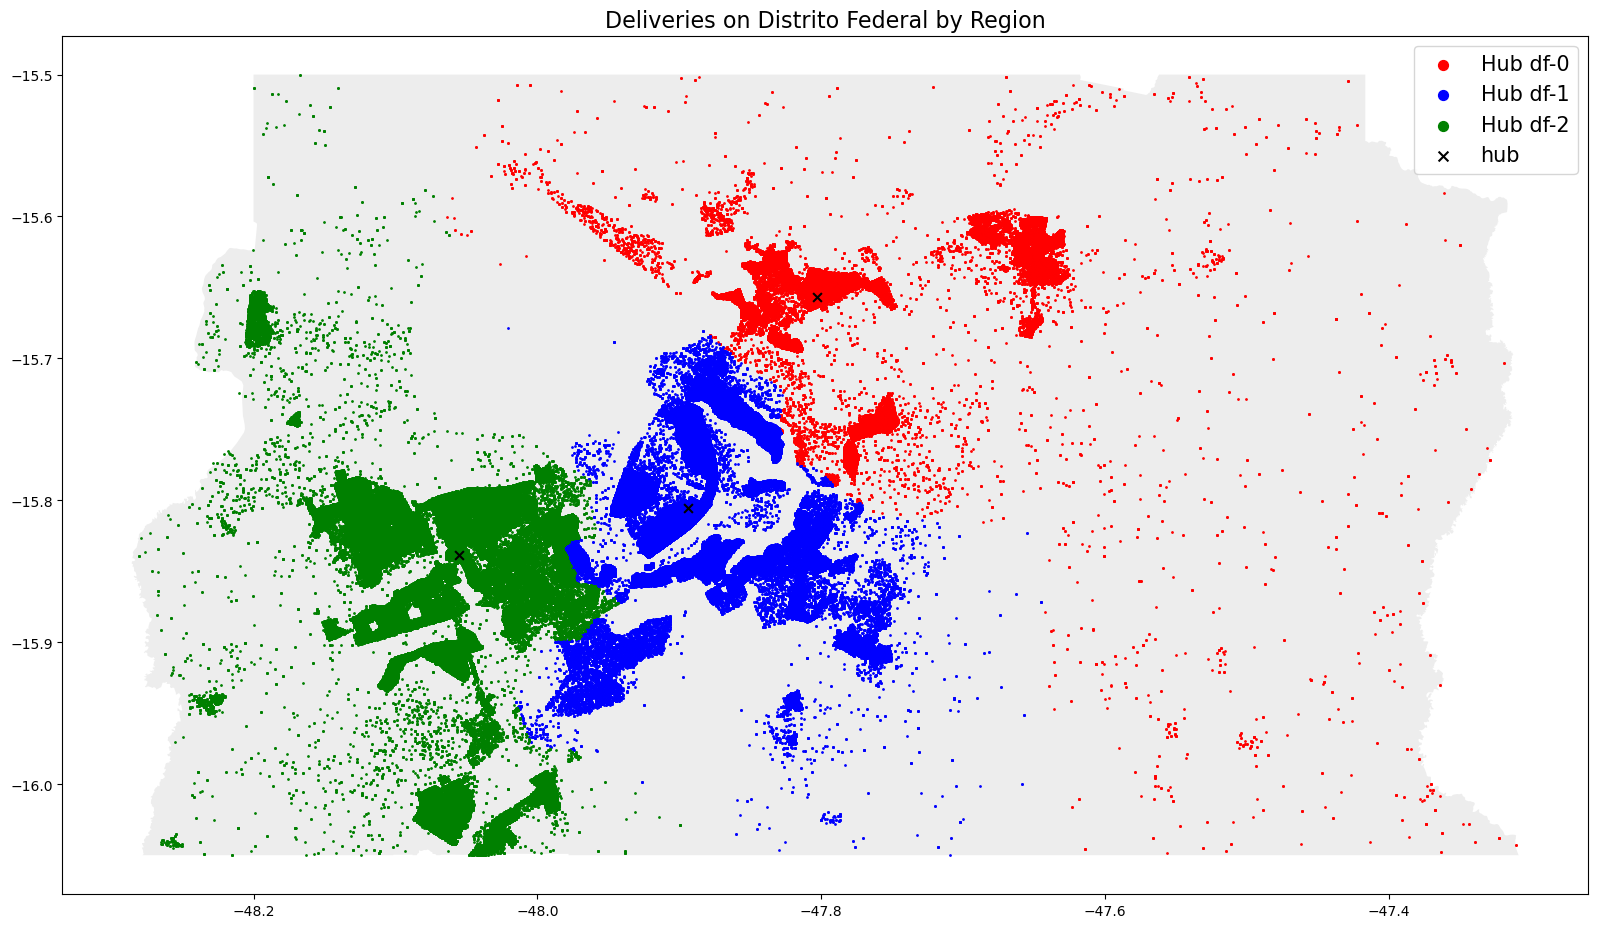

In [36]:
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

brmap.plot(ax = ax, alpha = 0.4, color = "lightgrey")

geo_dlv_df.query("region == 'df-0'").plot(ax = ax, markersize = 1, color = "red", label = "Hub df-0")
geo_dlv_df.query("region == 'df-1'").plot(ax = ax, markersize = 1, color = "blue", label = "Hub df-1")
geo_dlv_df.query("region == 'df-2'").plot(ax = ax, markersize = 1, color = "green", label = "Hub df-2")

geo_hub_df.plot(ax = ax, markersize = 40, marker = "x", color = "black", label = "hub")

plt.title("Deliveries on Distrito Federal by Region", fontdict = {"fontsize": 16})

legend = plt.legend(prop = {"size": 15})

for handle in legend.legendHandles:
    handle.set_sizes([50])

We see a large coverage of deliveries in region 0 and 2, whereas hub 1 concentrates deliveries in the central region

An important thing to see is how the deliveries are divided by region

In [37]:
data = pd.DataFrame(df[["region","vehicle_capacity"]].value_counts(normalize = True)).reset_index()
data.rename(columns = {0: "region_percent"}, inplace = True)
data.head()

,region,vehicle_capacity,region_percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


We see that the amount of deliveries in region 1 and 2 are much higher than in region 0

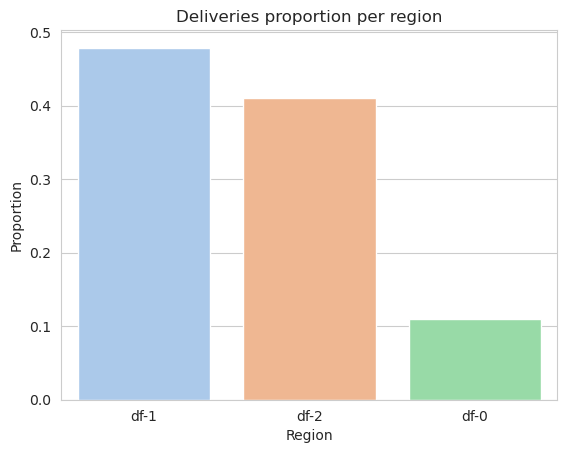

In [38]:
with sns.axes_style ("whitegrid"):
    grafico = sns.barplot(data = data, x = "region", y = "region_percent", errorbar = None, palette = "pastel")
    grafico.set(title = "Deliveries proportion per region", xlabel = "Region", ylabel = "Proportion");